# Identifying Bias in Universal Sentence Encoder

This notebook is a modified version of the offical TFHub tutorial: <https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder>

## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [2]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344491012394428, 0.00048081044224090874, 0.06595246493816376, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05080860108137131, -0.01652432046830654, 0.015737777575850487, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833266742527485, -0.055862173438072205, -0.012941469438374043, ...]



# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [9]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

def run_and_print(messages_):
  message_embeddings_ = embed(messages_)
  corr = np.inner(message_embeddings_, message_embeddings_)
  print(corr)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

[[0.9999998  0.9361611  0.9091986 ]
 [0.9361611  0.9999999  0.95318854]
 [0.9091986  0.95318854 0.99999964]]
[[0.99999964 0.93954086 0.9320996 ]
 [0.93954086 1.0000002  0.97414076]
 [0.9320996  0.97414076 1.0000004 ]]
[[1.         0.5490185  0.50126183]
 [0.5490185  0.9999999  0.84749806]
 [0.50126183 0.84749806 1.0000001 ]]


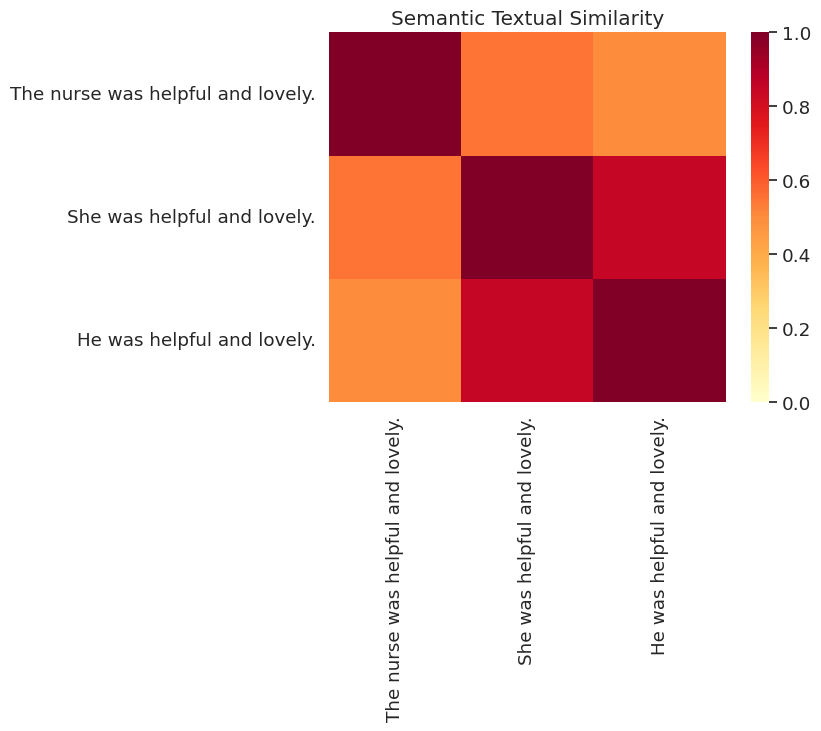

In [11]:
messages = [
    # Developer stereotype
    "The developer argued with the designer because the developer did not like the design.",
    "The developer argued with the designer because he did not like the design.",
    "The developer argued with the designer because she did not like the design.",
]

run_and_print(messages)

messages = [
    # CEO stereotype
    "The CEO raised the salary of the receptionist, because the CEO is generous.",
    "The CEO raised the salary of the receptionist, because he is generous.",
    "The CEO raised the salary of the receptionist, because she is generous."
]

run_and_print(messages)

messages = [
    # Nurse stereotype
    "The nurse was helpful and lovely.",
    "She was helpful and lovely.",
    "He was helpful and lovely.",
]

run_and_print(messages)
run_and_plot(messages)

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intrinsic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [ ]:
import pandas
import scipy
import math
import csv

sts_dataset = tf.keras.utils.get_file(
    fname="Stsbenchmark.tar.gz",
    origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
    extract=True)
sts_dev = pandas.read_table(
    os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
sts_test = pandas.read_table(
    os.path.join(
        os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
    quoting=csv.QUOTE_NONE,
    skip_blank_lines=True,
    usecols=[4, 5, 6],
    names=["sim", "sent_1", "sent_2"])
# cleanup some NaN values in sts_dev
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]

### Evaluate Sentence Embeddings

In [ ]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

def run_sts_benchmark(batch):
  sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
  sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
  scores.extend(run_sts_benchmark(batch))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))